16:36:31 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
C:\Users\rites\AppData\Local\Temp\ipykernel_5788\780598336.py:60: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


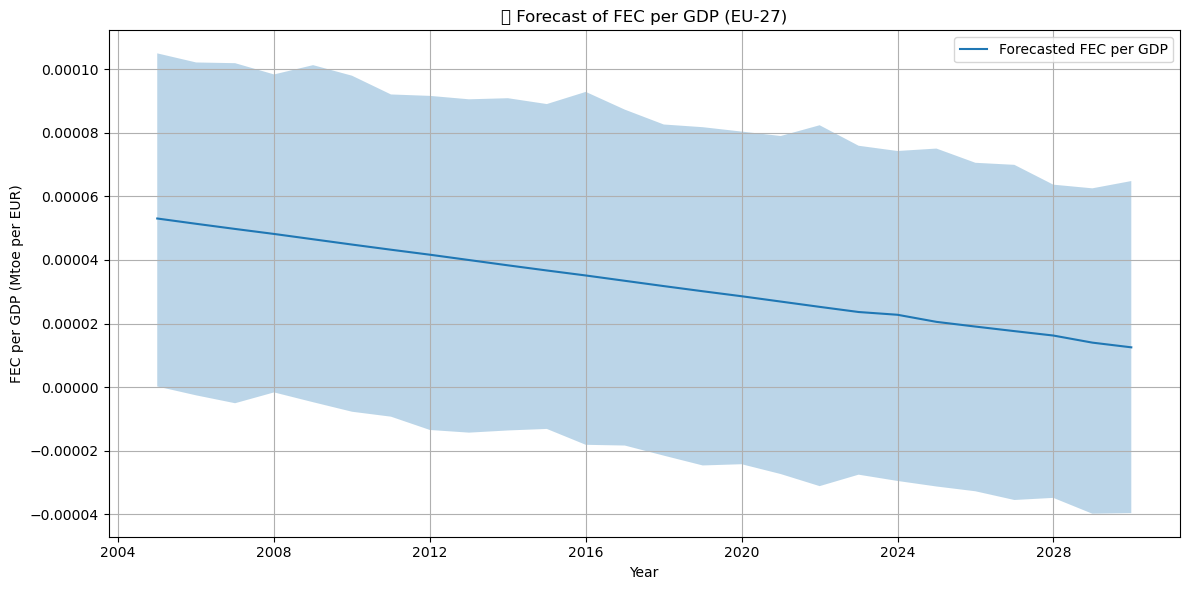

✅ Saved: FEC_per_GDP_Forecast.xlsx


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the datasets
fec_df = pd.read_excel("C:/Users/rites/Downloads/FEC.xlsx")
gdp_df = pd.read_excel("C:/Users/rites/Downloads/GDP.xlsx")

# === Clean and Prepare Data ===

# Rename columns
fec_df.rename(columns={fec_df.columns[0]: "Country", fec_df.columns[1]: "Unit"}, inplace=True)
gdp_df.rename(columns={gdp_df.columns[0]: "Country"}, inplace=True)

# Reshape to long format
fec_long = fec_df.melt(id_vars=["Country", "Unit"], var_name="Year", value_name="FEC")
gdp_long = gdp_df.melt(id_vars=["Country"], var_name="Year", value_name="GDP")

# Convert values
fec_long["Year"] = pd.to_numeric(fec_long["Year"], errors="coerce")
fec_long["FEC"] = pd.to_numeric(fec_long["FEC"], errors="coerce")
gdp_long["Year"] = pd.to_numeric(gdp_long["Year"], errors="coerce")
gdp_long["GDP"] = pd.to_numeric(gdp_long["GDP"], errors="coerce")

# Merge
merged = pd.merge(fec_long, gdp_long, on=["Country", "Year"])
merged["FEC_per_GDP"] = merged["FEC"] / merged["GDP"]

# Filter for EU-27
country_focus = "European Union - 27 countries (from 2020)"
df = merged[merged["Country"] == country_focus].dropna(subset=["FEC_per_GDP"])

# === Forecasting ===

df_prophet = df[["Year", "FEC_per_GDP"]].copy()
df_prophet["ds"] = pd.to_datetime(df_prophet["Year"], format='%Y')
df_prophet.rename(columns={"FEC_per_GDP": "y"}, inplace=True)

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=7, freq="Y")
forecast = model.predict(future)

# Calculate YoY efficiency gain
forecast["year"] = forecast["ds"].dt.year
forecast["efficiency_gain_YoY"] = forecast["yhat"].pct_change() * 100

# === Plots ===

plt.figure(figsize=(12, 6))
plt.plot(forecast["ds"], forecast["yhat"], label="Forecasted FEC per GDP")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], alpha=0.3)
plt.title("📈 Forecast of FEC per GDP (EU-27)")
plt.xlabel("Year")
plt.ylabel("FEC per GDP (Mtoe per EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Export Table ===
forecast[["ds", "yhat", "efficiency_gain_YoY"]].to_excel("FEC_per_GDP_Forecast.xlsx", index=False)
print("✅ Saved: FEC_per_GDP_Forecast.xlsx")


In [2]:
pip install plotly

   ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
   --- ------------------------------------ 1.3/16.3 MB 9.6 MB/s eta 0:00:02
   -------------- ------------------------- 5.8/16.3 MB 16.8 MB/s eta 0:00:01
   ---------------------------- ----------- 11.5/16.3 MB 20.6 MB/s eta 0:00:01
   ---------------------------------------- 16.3/16.3 MB 21.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


C:\Users\rites\AppData\Local\Temp\ipykernel_5788\2984715665.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


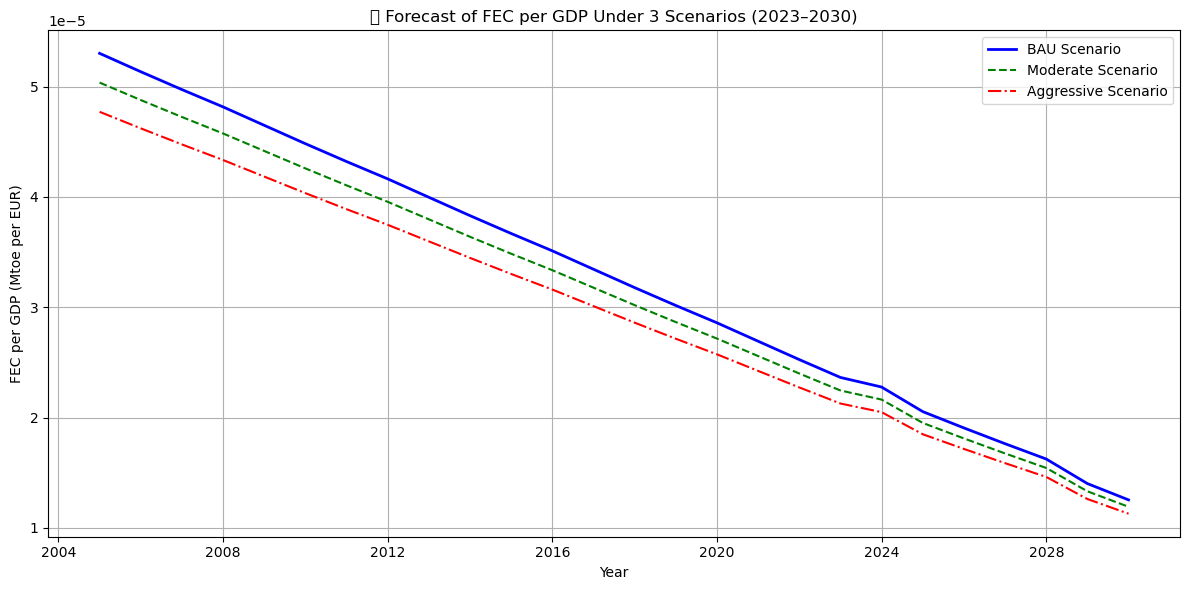

📊 CAGR (2023–2030):
BAU:        -10.04%
Moderate:   -10.04%
Aggressive: -10.04%
✅ Full forecast with scenarios saved to: FEC_per_GDP_Forecast_Scenarios.xlsx


In [5]:
# Define scenarios based on yhat
forecast["BAU"] = forecast["yhat"]
forecast["Moderate"] = forecast["yhat"] * 0.95
forecast["Aggressive"] = forecast["yhat"] * 0.90

# Calculate YoY % change for each scenario
forecast["BAU_YoY"] = forecast["BAU"].pct_change() * 100
forecast["Moderate_YoY"] = forecast["Moderate"].pct_change() * 100
forecast["Aggressive_YoY"] = forecast["Aggressive"].pct_change() * 100

# Calculate CAGR for 2023–2030
def calculate_cagr(start, end, years):
    return ((end / start) ** (1 / years) - 1) * 100

# Plot all three scenarios on one graph
plt.figure(figsize=(12, 6))
plt.plot(forecast["ds"], forecast["BAU"], label="BAU Scenario", color="blue", linewidth=2)
plt.plot(forecast["ds"], forecast["Moderate"], label="Moderate Scenario", color="green", linestyle="--")
plt.plot(forecast["ds"], forecast["Aggressive"], label="Aggressive Scenario", color="red", linestyle="-.")
plt.title("📉 Forecast of FEC per GDP Under 3 Scenarios (2023–2030)")
plt.xlabel("Year")
plt.ylabel("FEC per GDP (Mtoe per EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Dynamically find last available forecast year
start_year = 2023
end_year = forecast["year"].max()

# Get scenario values for CAGR calculation
start_bau = forecast.loc[forecast["year"] == start_year, "BAU"].values[0]
end_bau = forecast.loc[forecast["year"] == end_year, "BAU"].values[0]
start_mod = forecast.loc[forecast["year"] == start_year, "Moderate"].values[0]
end_mod = forecast.loc[forecast["year"] == end_year, "Moderate"].values[0]
start_agg = forecast.loc[forecast["year"] == start_year, "Aggressive"].values[0]
end_agg = forecast.loc[forecast["year"] == end_year, "Aggressive"].values[0]


cagr_bau = calculate_cagr(start_bau, end_bau, end_year - start_year)
cagr_mod = calculate_cagr(start_mod, end_mod, end_year - start_year)
cagr_agg = calculate_cagr(start_agg, end_agg, end_year - start_year)

# Display CAGR results
print("📊 CAGR (2023–2030):")
print(f"BAU:        {cagr_bau:.2f}%")
print(f"Moderate:   {cagr_mod:.2f}%")
print(f"Aggressive: {cagr_agg:.2f}%")

# === Export Full Forecast Table ===
forecast.to_excel("FEC_per_GDP_Forecast_Scenarios.xlsx", index=False)
print("✅ Full forecast with scenarios saved to: FEC_per_GDP_Forecast_Scenarios.xlsx")


In [6]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform time-based rolling cross-validation
df_cv = cross_validation(model, initial='3650 days', period='365 days', horizon='730 days')
df_perf = performance_metrics(df_cv)

print("📊 Cross-Validation Performance Metrics:")
print(df_perf[['horizon', 'mape', 'rmse', 'coverage']])


12:24:43 - cmdstanpy - INFO - Chain [1] start processing
12:24:44 - cmdstanpy - INFO - Chain [1] done processing
12:24:44 - cmdstanpy - INFO - Chain [1] start processing
12:24:44 - cmdstanpy - INFO - Chain [1] done processing
12:24:44 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing
12:24:45 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing
12:24:45 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing
12:24:45 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing
12:24:46 - cmdstanpy - INFO - Chain [1] start processing
12:24:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


📊 Cross-Validation Performance Metrics:
   horizon       mape      rmse  coverage
0 364 days   6.876271  0.000036  0.833333
1 365 days  37.618265  0.000034  0.833333
2 729 days   6.718148  0.000036  0.833333
3 730 days  26.245269  0.000034  0.833333


In [7]:
# Check prediction coverage: are actuals within yhat_lower/yhat_upper?
df_cv['covered'] = ((df_cv['y'] >= df_cv['yhat_lower']) & (df_cv['y'] <= df_cv['yhat_upper']))
coverage_rate = df_cv['covered'].mean()
mean_interval_width = (df_cv['yhat_upper'] - df_cv['yhat_lower']).mean()

print(f"\n Prediction Interval Coverage Rate: {coverage_rate:.2%}")
print(f" Mean Prediction Interval Width: {mean_interval_width:.2e}")



✅ Prediction Interval Coverage Rate: 83.33%
📐 Mean Prediction Interval Width: 1.01e-04


C:\Users\rites\AppData\Local\Temp\ipykernel_5788\770400931.py:11: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x400 with 0 Axes>

C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


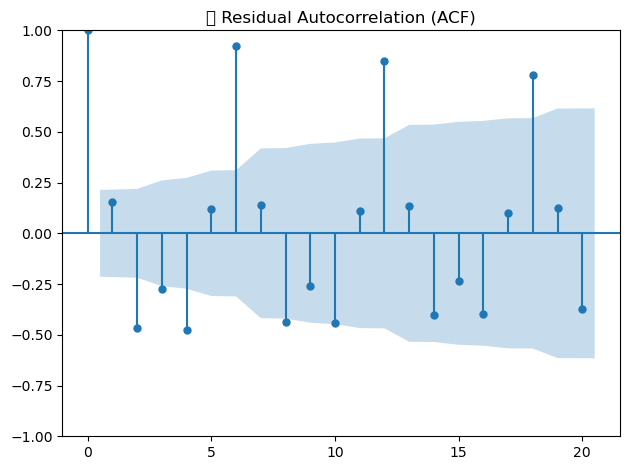

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

# Calculate residuals
df_cv['residuals'] = df_cv['y'] - df_cv['yhat']

# Plot autocorrelation of residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plot_acf(df_cv['residuals'].dropna(), lags=20)
plt.title(" Residual Autocorrelation (ACF)")
plt.tight_layout()
plt.show()



In [9]:
# Hypothetical CO2 saved from reduction in FEC/GDP
baseline = forecast.loc[forecast['year'] == 2023, 'yhat'].values[0]
forecast['CO2_saved'] = (baseline - forecast['yhat']) * 100  # scaled value
emission_price = 85  # €/tonne
forecast['Emission_ROI'] = forecast['CO2_saved'] * emission_price

roi_total = forecast['Emission_ROI'].sum()
print(f" Estimated Total Emission-Linked ROI: €{roi_total:,.0f}")


🌍 Estimated Total Emission-Linked ROI: €-2


C:\Users\rites\AppData\Local\Temp\ipykernel_5788\1020411052.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


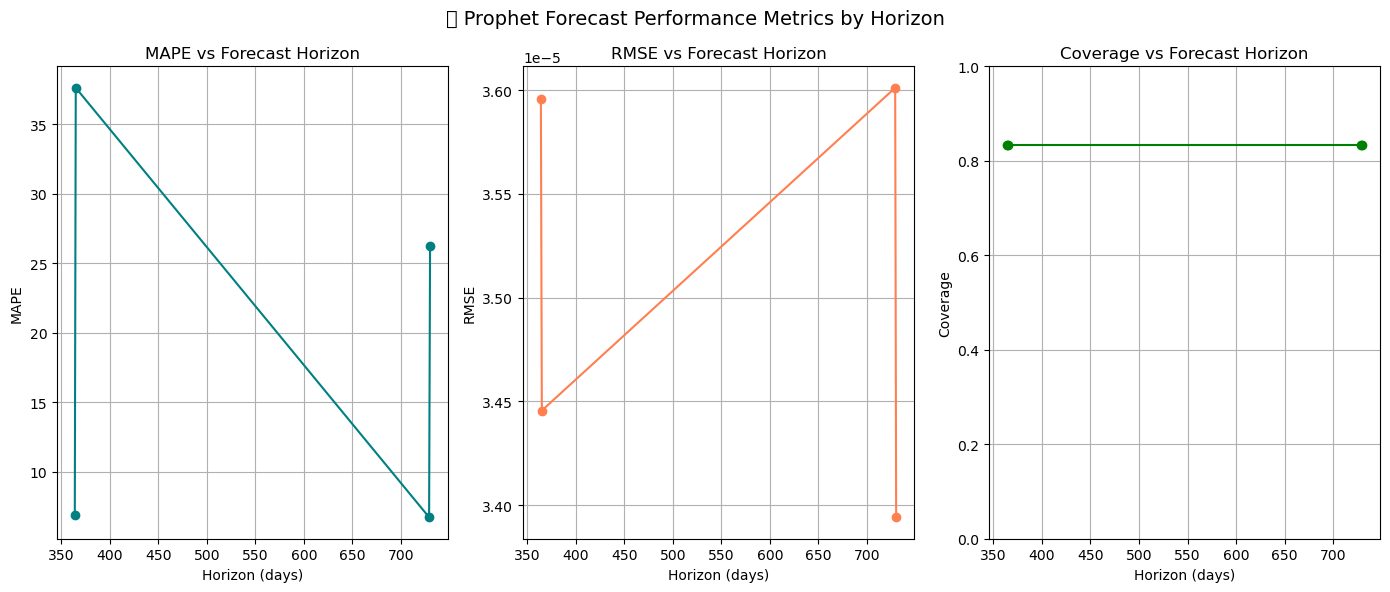

In [10]:
import matplotlib.pyplot as plt

# Ensure horizons are in numeric days
df_perf['horizon_days'] = df_perf['horizon'].apply(lambda x: int(str(x).split()[0]))

plt.figure(figsize=(14, 6))

# Plot MAPE
plt.subplot(1, 3, 1)
plt.plot(df_perf['horizon_days'], df_perf['mape'], marker='o', color='teal')
plt.title('MAPE vs Forecast Horizon')
plt.xlabel('Horizon (days)')
plt.ylabel('MAPE')
plt.grid(True)

# Plot RMSE
plt.subplot(1, 3, 2)
plt.plot(df_perf['horizon_days'], df_perf['rmse'], marker='o', color='coral')
plt.title('RMSE vs Forecast Horizon')
plt.xlabel('Horizon (days)')
plt.ylabel('RMSE')
plt.grid(True)

# Plot Coverage
plt.subplot(1, 3, 3)
plt.plot(df_perf['horizon_days'], df_perf['coverage'], marker='o', color='green')
plt.title('Coverage vs Forecast Horizon')
plt.xlabel('Horizon (days)')
plt.ylabel('Coverage')
plt.ylim(0, 1)
plt.grid(True)

plt.suptitle(" Prophet Forecast Performance Metrics by Horizon", fontsize=14)
plt.tight_layout()
plt.show()
